In [21]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from pandas import set_option
set_option("display.max_rows", 16)

LARGE_FIGSIZE = (12, 8)

In [2]:
# read data from the Excel file
data=pd.read_excel('./Direktvermarktung-Uebersicht_Jan_2016.xlsx',sheetname='DV-MPM')
data

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Mrz,Apr,Mai,Jun,Jul,Aug,Sep,Okt,Nov,Dez
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# print the and its type
print data
type(data)

                   ÜNB  Netzbetreiber Betriebsnummer  \
0              Amprion                    10001607.0   
1              Amprion                    10003764.0   
2              Amprion                    10001607.0   
3              Amprion                    10003764.0   
4              Amprion                    10003764.0   
5              Amprion                    10003764.0   
6              Amprion                    10000055.0   
7              Amprion                    10000055.0   
...                ...                           ...   
32456  TransnetBW GmbH                    10003223.0   
32457  TransnetBW GmbH                    10000843.0   
32458  TransnetBW GmbH                    10000843.0   
32459  TransnetBW GmbH                    10000843.0   
32460  TransnetBW GmbH                    10000843.0   
32461  TransnetBW GmbH                    10001495.0   
32462  TransnetBW GmbH                    10002974.0   
32463  TransnetBW GmbH                    100008

pandas.core.frame.DataFrame

In [4]:
# encode Energietraeger to integer class labels:
from sklearn import preprocessing
encodeEnergietr = preprocessing.LabelEncoder()
data["Energietraeger_enc"]=encodeEnergietr.fit_transform(data["Energietraeger"])

In [5]:
data

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Apr,Mai,Jun,Jul,Aug,Sep,Okt,Nov,Dez,Energietraeger_enc
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
from sklearn.cross_validation import train_test_split
variables = ["Installierte Leistung in kW"]

X=data[variables].values
y=data["Energietraeger_enc"]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=1999)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)
#pred_score = classifier.decision_function(test_X)
print("Fraction Correct")
print(np.sum(pred_y == test_y) / float(len(test_y)))

Fraction Correct
0.672498767866


test score   0.672498767866
train score  0.687161163135


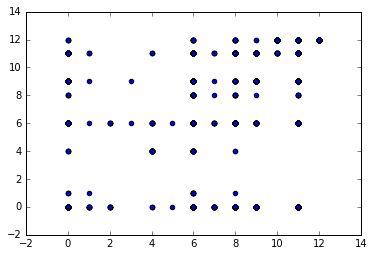

In [8]:
print "test score  ", classifier.score(test_X, test_y)

print "train score ", classifier.score(train_X, train_y)

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)


In [9]:
pred_y

array([ 0, 11,  9, ..., 11,  9,  0], dtype=int64)

In [10]:
# read PLZ data:
plz=pd.read_csv("PLZ.tab", sep="\t")
plz["PLZ"]=plz["plz"]
plz

,#loc_id,plz,lon,lat,Ort,PLZ
0,5078,1067,13.721068,51.060034,Dresden,1067
1,5079,1069,13.738907,51.039559,Dresden,1069
2,5080,1097,13.743967,51.066745,Dresden,1097
3,5081,1099,13.828980,51.092619,Dresden,1099
4,153646,1108,13.828980,51.092619,Dresden,1108
5,5082,1109,13.761965,51.120101,Dresden,1109
6,5083,1127,13.733347,51.079630,Dresden,1127
7,5084,1129,13.727410,51.096794,Dresden,1129
...,...,...,...,...,...,...
8281,12805,99974,10.458195,51.243633,Mühlhausen,99974


In [11]:
# join data with PLZ:
data2 = pd.merge(data, plz, how='left', on="PLZ").fillna(0.)
data2

,ÜNB,Netzbetreiber Betriebsnummer,Netzbetreiber Name,Anlagenschlüssel,Ort/Gemarkung,PLZ,Straße/Flurstück,Installierte Leistung in kW,Einspeisespannungsebene,Energietraeger,...,Sep,Okt,Nov,Dez,Energietraeger_enc,#loc_id,plz,lon,lat,Ort
0,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E10843010000000000000027491500001,Itterbeck,49847,Strasse,190.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8304.0,49847.0,6.751713,52.515639,Itterbeck
1,Amprion,10003764.0,WESTNETZ GmbH,E12974010000000000000028502300001,Twist,49767,Strasse,265.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8288.0,49767.0,7.095613,52.668487,Twist
2,Amprion,10001607.0,nvb Nordhorner Versorgungsbetriebe GmbH,E20793012000000000000020354720001,Laar,49824,Strasse,526.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8296.0,49824.0,6.844740,52.615410,Emlichheim
3,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157876700001,Haren,49733,Strasse,250.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8282.0,49733.0,7.199469,52.797957,Haren (Ems)
4,Amprion,10003764.0,WESTNETZ GmbH,E21846010000000000001157933000001,Haren,49733,Strasse,250.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8282.0,49733.0,7.199469,52.797957,Haren (Ems)
5,Amprion,10003764.0,WESTNETZ GmbH,E218780100000E0000000005024800001,Recke,49509,Strasse,350.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,8253.0,49509.0,7.704652,52.364821,Recke
6,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW01,Hinterstein,87541,Strasse,530.0,MS,Wasserkraft,...,0.0,0.0,0.0,0.0,8,11413.0,87541.0,10.399859,47.472895,Hindelang
7,Amprion,10000055.0,Elektrizitätswerk Hindelang eG,E30055018754104413050013992EEGW02,Hinterstein,87541,Strasse,550.0,MS,Wasserkraft,...,0.0,0.0,0.0,0.0,8,11413.0,87541.0,10.399859,47.472895,Hindelang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32456,TransnetBW GmbH,10003223.0,Stadtwerke Heidelberg Netze GmbH,E10765010000000000010000092680001,Heidelberg,69123,Straße/Flurstück,750.0,MS,Biomasse,...,0.0,0.0,0.0,0.0,0,9638.0,69123.0,8.628442,49.417402,Heidelberg


In [12]:
# use lat/lon:
from sklearn.cross_validation import train_test_split
variables = ["Installierte Leistung in kW", "lat", "lon"]


#variables = ["Installierte Leistung in kW", "Geothermie",
#             "Solar", "Wasser", "Wind"]
#lables = [ "Geothermie", "Solar", "Wasser", "Wind"]


X=data2[variables].values
y=data2["Energietraeger_enc"]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=1999)

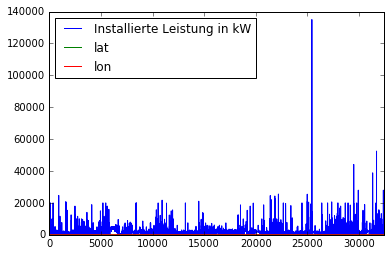

In [13]:
data2[variables].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000114BC710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A3CD550>]], dtype=object)

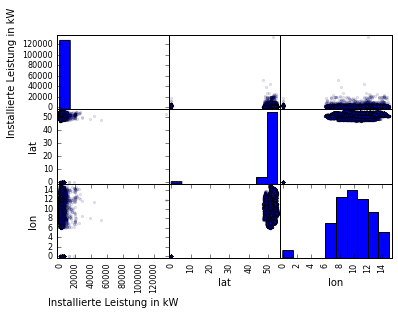

In [22]:
pd.scatter_matrix(data2[variables], alpha=0.1)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)
print("Fraction Correct")
print(np.sum(pred_y == test_y) / float(len(test_y)))

Fraction Correct
0.88442582553


test score   0.88442582553
train score  0.917015771316


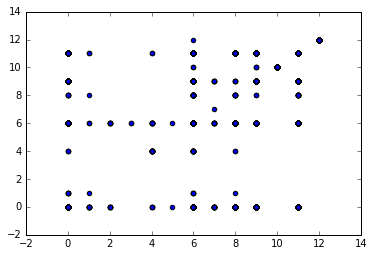

In [17]:
print "test score  ", classifier.score(test_X, test_y)

print "train score ", classifier.score(train_X, train_y)

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)

[[ 834    5    0    0    9    0  458   11   43 1005   13 1372   74]
 [   2    0    0    0    0    0    2    0    0    2    0    4    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   6    1    0    0    0    0    3    0    0    8    1   14    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 405    1    0    0    3    1  176    1   15  410    6  581   41]
 [   0    0    0    0    0    0    0    0    0    0    0    1    0]
 [   9    0    0    0    0    0    7    0    2    5    0   21    2]
 [ 897    4    2    0    8    0  476    6   30  988   11 1580   81]
 [  15    0    0    0    0    0    7    0    4    7    0   25    1]
 [1349   12    9    1   14    0  724   11   65 1538   14 2318  119]
 [  82    0    0    0    0    0   47    3    0   82    2  135    9]]


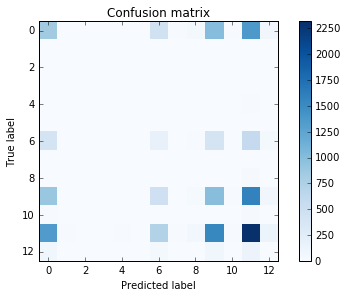

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(13)
    #plt.xticks(tick_marks, data["Index"], rotation=45)
    #plt.yticks(tick_marks, data["Index"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# test how well the prediction worked.
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(pred_y, train_y)
print (cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[  2.18096234e-01   1.30753138e-03   0.00000000e+00   0.00000000e+00
    2.35355649e-03   0.00000000e+00   1.19769874e-01   2.87656904e-03
    1.12447699e-02   2.62813808e-01   3.39958159e-03   3.58786611e-01
    1.93514644e-02]
 [  1.81818182e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.81818182e-01   0.00000000e+00
    0.00000000e+00   1.81818182e-01   0.00000000e+00   3.63636364e-01
    9.09090909e-02]
 [             nan              nan              nan              nan
               nan              nan              nan              nan
               nan              nan              nan              nan
               nan]
 [             nan              nan              nan              nan
               nan              nan              nan              nan
               nan              nan              nan              nan
               nan]
 [  1.76470588e-01   2.94117647e-02   0.00000000e+00

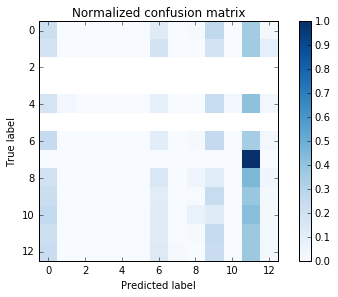

In [19]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()